In [1]:
import numpy as np
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import sys
from PIL import Image, ImageSequence
import cv2
import scipy as sp

In [2]:
os.chdir('D:/project2/ToD/data/image1')
plt.rcParams["figure.figsize"] = (13,13)

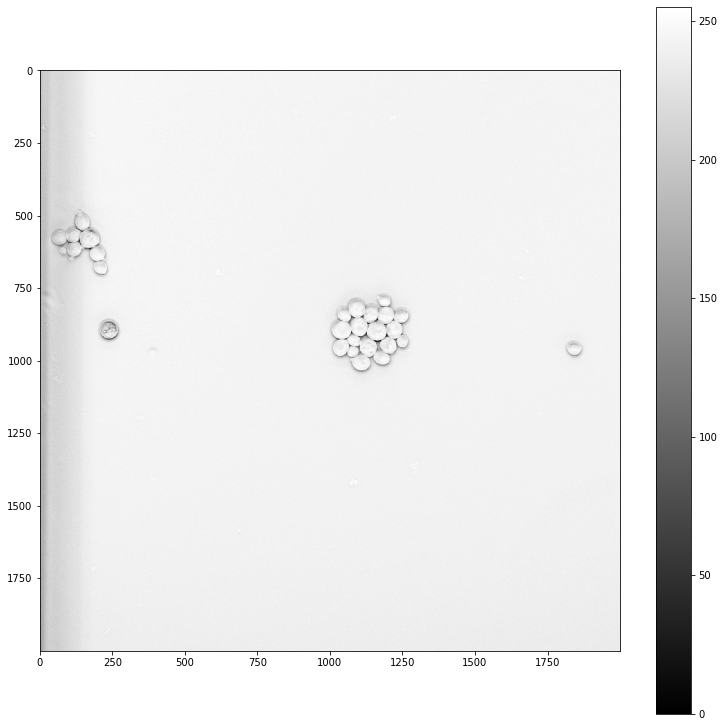

In [3]:
kuk = 48
i=kuk
img = cv2.imread('image'+str(i)+'.png')
gray = 255-cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(gray, cmap = 'gray')
plt.colorbar()

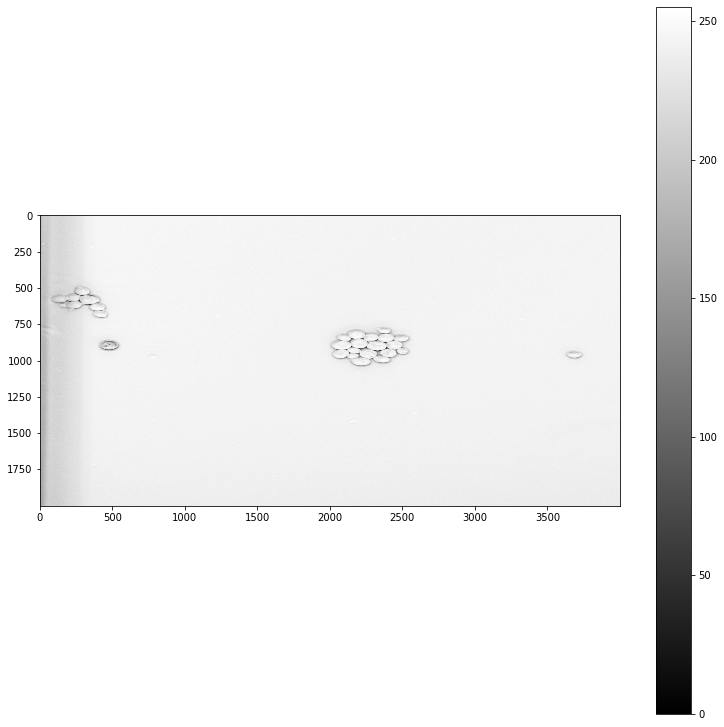

In [4]:
stretched = np.repeat(gray, 2, axis=1)
plt.imshow(stretched, cmap = 'gray')
plt.colorbar()

In [5]:
axis = 1
factor = 1.25

indices = np.linspace(0, stretched.shape[axis] - 1, int(img.shape[axis] * factor))
indices = np.rint(indices).astype(int)

result = np.take(stretched, indices, axis=axis)
print(result.shape)  # (512, 640)

(2000, 2500)


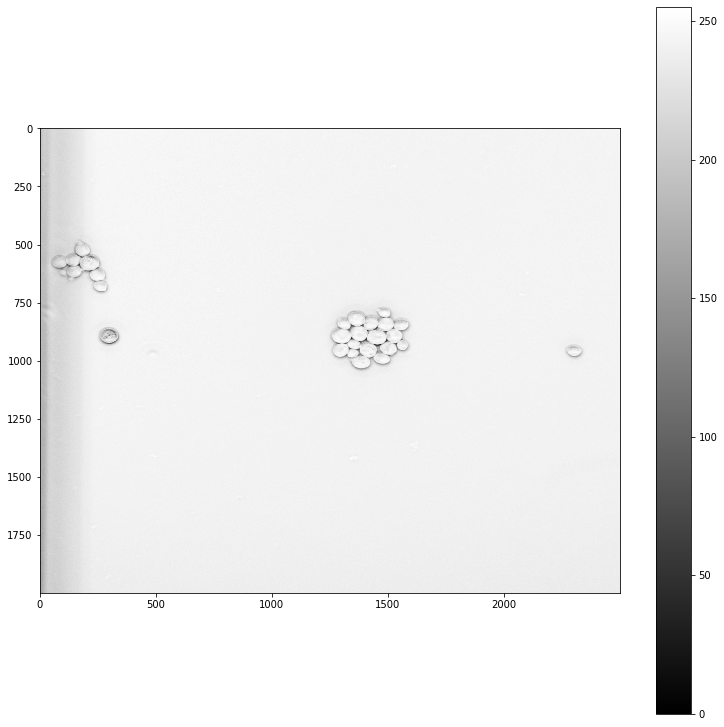

In [6]:
plt.imshow(result, cmap = 'gray')
plt.colorbar()

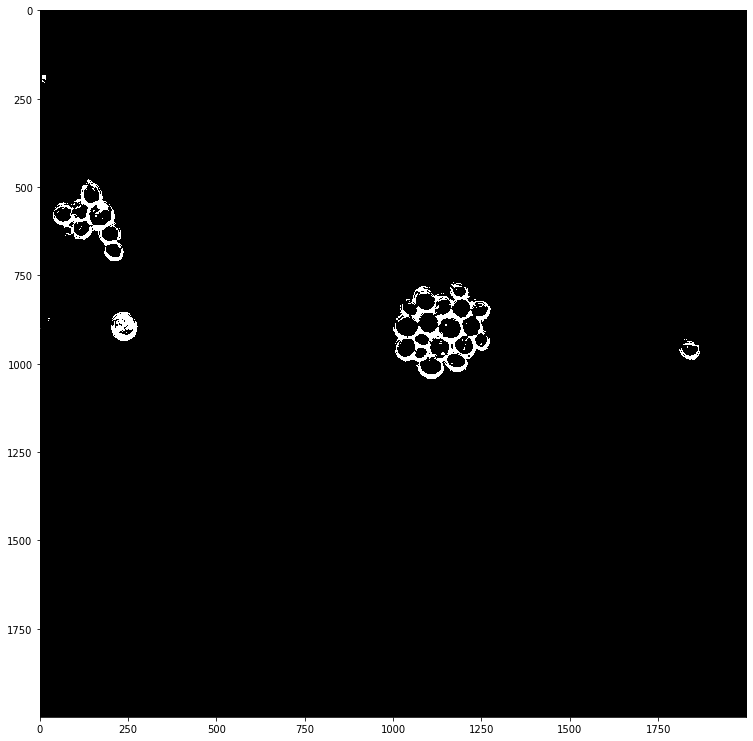

In [7]:
# Insane processing

#normalize
a = np.array(gray)
a = a-a.min()
a = 2.5*a/a.max()

#gradient (reduces slow gradients)
gradx, grady = np.gradient(np.array(a))
grad = np.sqrt(gradx**2+grady**2)

#filter noise:
#choose kernel
kernel = np.array([[2,2,2],[2,10,2],[2,2,2]])
kernel = kernel / np.sum(kernel)
kernel = kernel.astype(np.float32)
#filter (twice)
gaus = cv2.filter2D(np.float32(grad),-1,kernel)
gaus = cv2.filter2D(np.float32(gaus),-1,kernel)

tr = gaus > 0.05

plt.imshow(tr, cmap = 'gray')

dil = scipy.ndimage.binary_dilation(tr, iterations=6).astype(int)
close = scipy.ndimage.binary_closing(dil, iterations=6).astype(int)

sure_bg = scipy.ndimage.morphology.binary_fill_holes(close).astype(int)

prod = a*sure_bg

dil = prod < 2.2


dil = scipy.ndimage.binary_erosion(dil, iterations=1).astype(int)
dil = scipy.ndimage.binary_dilation(dil, iterations=8).astype(int)
dil = scipy.ndimage.binary_erosion(dil, iterations=2).astype(int)

sure_fg = 1 - dil
sure_fg[-40:,:]=0
sure_fg[:40,:]=0
sure_fg[:,-40:]=0
sure_fg[:,:40]=0

unknown = sure_bg - sure_fg

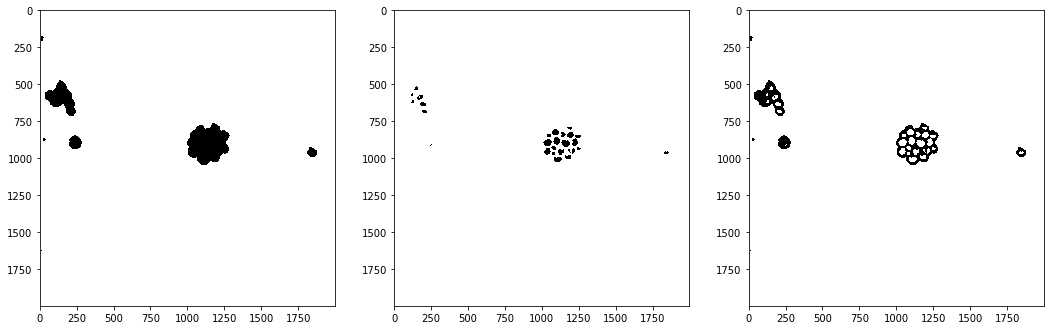

In [8]:
f, axarr = plt.subplots(1,3,figsize=(18, 6))
axarr[0].imshow(sure_bg, cmap = 'Greys')
axarr[1].imshow(sure_fg, cmap = 'Greys')
axarr[2].imshow(unknown, cmap = 'Greys')

In [9]:
sure_bg = np.uint8(sure_bg*255)
sure_fg = np.uint8(sure_fg*255)
unknown = np.uint8(unknown*255)

In [10]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [11]:
#plt.imshow(markers, cmap='jet')

In [12]:
cells = []
for i in range(1,markers.max()+1):
    cell = markers==i
    cell = scipy.ndimage.binary_dilation(cell, iterations=4).astype(int)
    cellX = scipy.ndimage.binary_dilation(cell, iterations=5).astype(int)
    border = (cellX - cell)*1000
    cell = i*cell+border
    cells.append(cell)

In [13]:
tot = np.ones(cell.shape)
for i in range(len(cells)):
    where = cells[i]!=0
    tot[where] = cells[i][where]

In [14]:
tot[tot>999] = np.unique(tot)[-2] + 5

In [15]:
i=kuk

In [16]:
os.chdir('D:/project2/ToD/data/mask1')

img = cv2.imread('maks'+str(i)+'.png')
gray = 255-cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

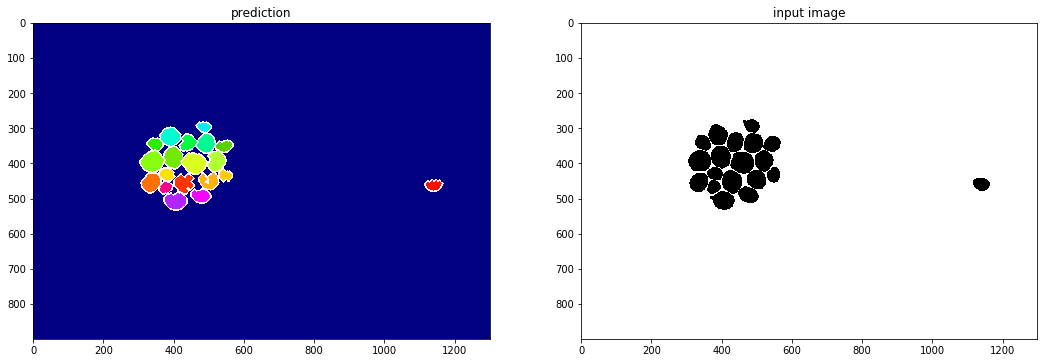

In [17]:
f, axarr = plt.subplots(1,2,figsize=(18, 6))
axarr[0].set_title('prediction')
axarr[0].imshow(tot[500:1400,700:], cmap='gist_ncar')
axarr[1].set_title('input image')
axarr[1].imshow(gray[500:1400,700:], cmap='gray')

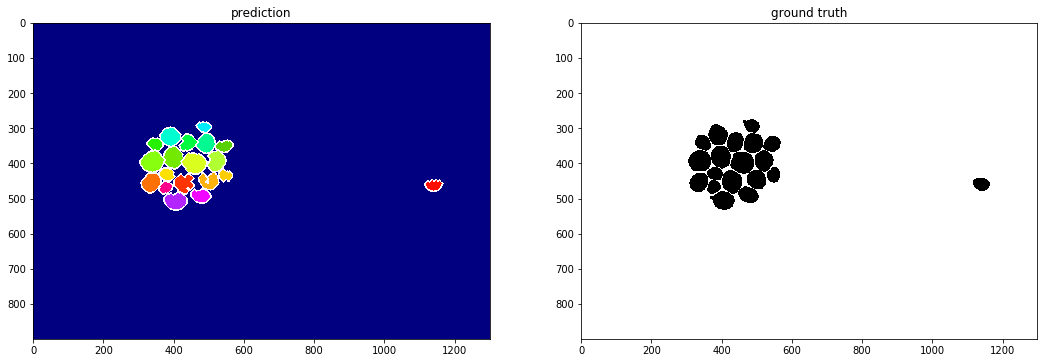

In [18]:
f, axarr = plt.subplots(1,2,figsize=(18, 6))
axarr[0].set_title('prediction')
axarr[0].imshow(tot[500:1400,700:], cmap='gist_ncar')
axarr[1].set_title('ground truth')
axarr[1].imshow(gray[500:1400,700:], cmap='gray')

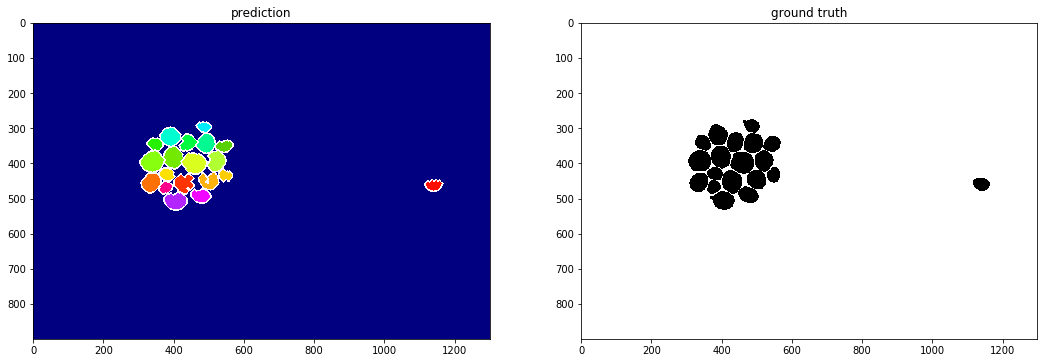

In [19]:
f, axarr = plt.subplots(1,2,figsize=(18, 6))
axarr[0].set_title('prediction')
axarr[0].imshow(tot[500:1400,700:], cmap='gist_ncar')
axarr[1].set_title('ground truth')
axarr[1].imshow(gray[500:1400,700:], cmap='gray')

In [20]:
tot = tot[500:1400,700:]
gray = gray[500:1400,700:]

In [21]:
tot = tot == 1

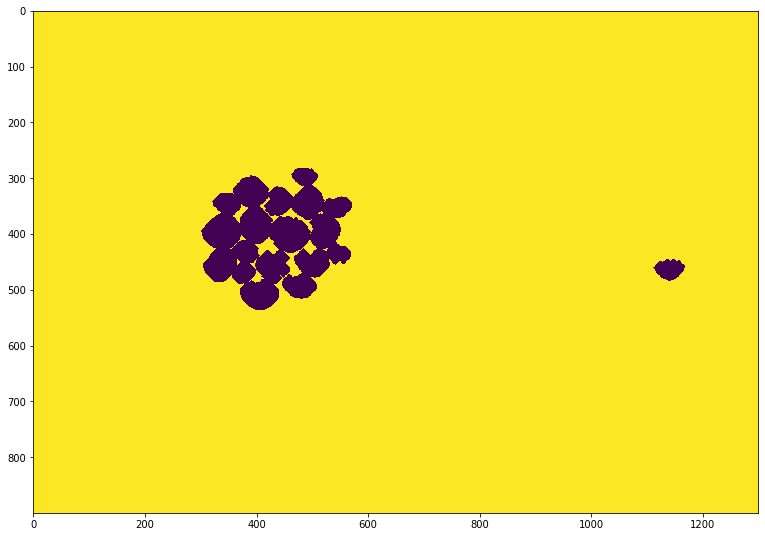

In [22]:
plt.imshow(tot)

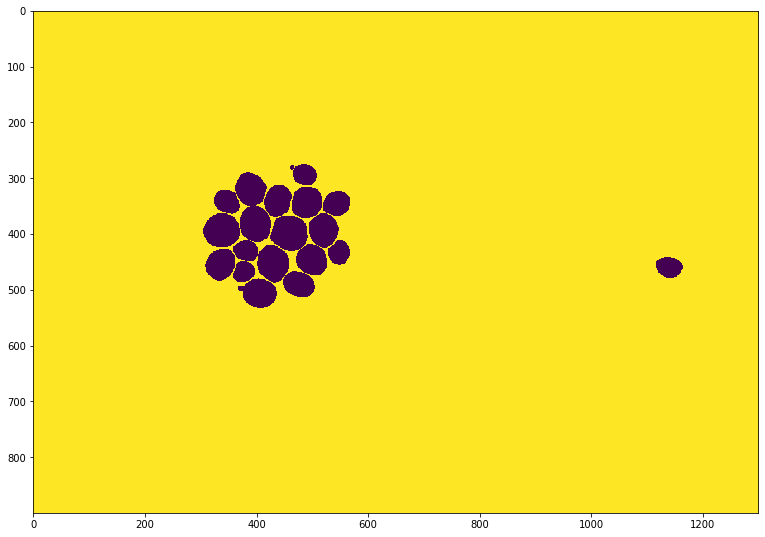

In [23]:
plt.imshow(gray)

In [24]:
dif = tot.astype(int)-(gray==255).astype(int)

In [25]:
dif = np.abs(dif)

In [26]:
dif.sum()

7561

In [27]:
# pixel accuracy
(1170000-dif.sum())/1170000

0.9935376068376068

In [28]:
tot = tot==0

In [29]:
# dice coefficient
(tot*(gray==0)*2).sum()/((gray==0).sum()+tot.sum())

0.909821694793965